In [1]:
!pip install albumentations==0.4.6

In [2]:
import albumentations
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import cv2 as cv
import sys
import importlib
from datetime import datetime
from albumentations import Compose, GaussNoise, Resize, HorizontalFlip, Normalize, ToGray, ShiftScaleRotate
from albumentations.pytorch import ToTensorV2
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook as tqdm

In [3]:
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-16GB


In [4]:
sys.path.append(os.path.abspath('/content/drive/My Drive/Colab Notebooks'))

In [5]:
from Train.Train import Train
from Dataset.DFDC import DFDC
from Eval.Eval import Eval
from Models.Wsdan import WSDAN
from Utils import Wsdan_utils as utils

In [6]:
config_file_path = '/content/drive/My Drive/Colab Notebooks/Config/EfficientB0_Wsdan.py'
visualize_save_path = "/content/drive/MyDrive/Colab Notebooks/Visualize"

import_spec = importlib.util.spec_from_file_location("config", config_file_path)
config = importlib.util.module_from_spec(import_spec)
import_spec.loader.exec_module(config)

In [7]:
TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [8]:
data_transforms = Compose([
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv.BORDER_CONSTANT, p=0.5),
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

data_transforms_test = Compose([
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [9]:
train_image_datasets = DFDC(TRAINING_DATA_FOLDER, data_transforms)
test_image_datasets = DFDC(TESTING_DATA_FOLDER, data_transforms_test)

In [10]:
writer = SummaryWriter('/content/drive/MyDrive/Colab Notebooks/Tensorboard_Log/Pytorch_WS_DAN/'+str(datetime.now()))

In [11]:
random.seed(323)

In [12]:
device = torch.device("cuda:0")
criterion = nn.CrossEntropyLoss().to(device)
model = WSDAN(num_classes=config.num_classes, M=config.num_attentions, net=config.net)
optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

model = Train(model, train_image_datasets, device, writer, config, utils, batch_size=16)
model, loader = model.run(num_epochs=100, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Loaded pretrained weights for efficientnet-b0
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")



train Loss: 3.7480 Acc: 0.6239



val Loss: 1.0753 Acc: 0.7073

Epoch 2/100



train Loss: 4.1603 Acc: 0.6780



val Loss: 1.8419 Acc: 0.6634

Epoch 3/100



train Loss: 3.8647 Acc: 0.6939



val Loss: 1.5217 Acc: 0.6829

Epoch 4/100



train Loss: 3.5571 Acc: 0.7462



val Loss: 0.7315 Acc: 0.8049

Epoch 5/100



train Loss: 3.0707 Acc: 0.7766



val Loss: 1.6704 Acc: 0.7878

Epoch 6/100



train Loss: 3.0579 Acc: 0.8241



val Loss: 0.6471 Acc: 0.8195

Epoch 7/100



train Loss: 2.5729 Acc: 0.8314



val Loss: 0.7803 Acc: 0.8268

Epoch 8/100



train Loss: 2.5263 Acc: 0.8308



val Loss: 0.8561 Acc: 0.8049

Epoch 9/100



train Loss: 2.1210 Acc: 0.8758



val Loss: 0.5235 Acc: 0.8537

Epoch 10/100



train Loss: 1.9328 Acc: 0.8746



val Loss: 0.5168 Acc: 0.8610

Epoch 11/100



train Loss: 1.9142 Acc: 0.8758



val Loss: 0.6267 Acc: 0.8220

Epoch 12/100



train Loss: 1.7842 Acc: 0.8807



val Loss: 0.5995 Acc: 0.8683

Epoch 13/100



train Loss: 1.6982 Acc: 0.8892



val Loss: 0.5461 Acc: 0.8561

Epoch 14/100



train Loss: 1.6379 Acc: 0.8862



val Loss: 0.5711 Acc: 0.8561

Epoch 15/100



train Loss: 1.5670 Acc: 0.9002



val Loss: 0.4485 Acc: 0.8805

Epoch 16/100



train Loss: 1.5035 Acc: 0.8886



val Loss: 0.4342 Acc: 0.8829

Epoch 17/100



train Loss: 1.4086 Acc: 0.9087



val Loss: 0.7233 Acc: 0.8537

Epoch 18/100



train Loss: 1.4446 Acc: 0.9081



val Loss: 0.5307 Acc: 0.8732

Epoch 19/100



train Loss: 1.3120 Acc: 0.9294



val Loss: 0.4560 Acc: 0.8780

Epoch 20/100



train Loss: 1.2790 Acc: 0.9324



val Loss: 0.4084 Acc: 0.8780

Epoch 21/100



train Loss: 1.2404 Acc: 0.9257



val Loss: 0.4508 Acc: 0.8610

Epoch 22/100



train Loss: 1.2119 Acc: 0.9306



val Loss: 0.4436 Acc: 0.8732

Epoch 23/100



train Loss: 1.2301 Acc: 0.9215



val Loss: 0.4895 Acc: 0.8463

Epoch 24/100



train Loss: 1.2047 Acc: 0.9270



val Loss: 0.3992 Acc: 0.8854

Epoch 25/100



train Loss: 1.1632 Acc: 0.9391



val Loss: 0.4190 Acc: 0.8854

Epoch 26/100



train Loss: 1.1280 Acc: 0.9367



val Loss: 0.3971 Acc: 0.8854

Epoch 27/100



train Loss: 1.1410 Acc: 0.9288



val Loss: 0.4365 Acc: 0.8659

Epoch 28/100



train Loss: 1.1048 Acc: 0.9379



val Loss: 0.4245 Acc: 0.8707

Epoch 29/100



train Loss: 1.1616 Acc: 0.9300



val Loss: 0.4703 Acc: 0.8805

Epoch 30/100



train Loss: 1.1024 Acc: 0.9361



val Loss: 0.4612 Acc: 0.8878

Epoch 31/100



train Loss: 1.0784 Acc: 0.9361



val Loss: 0.4143 Acc: 0.8707

Epoch 32/100



train Loss: 1.0761 Acc: 0.9355



val Loss: 0.4180 Acc: 0.8780

Epoch 33/100



train Loss: 1.0460 Acc: 0.9483



val Loss: 0.4091 Acc: 0.8829

Epoch 34/100



train Loss: 1.0542 Acc: 0.9440



val Loss: 0.3889 Acc: 0.9000

Epoch 35/100



train Loss: 1.0337 Acc: 0.9464



val Loss: 0.3957 Acc: 0.8854

Epoch 36/100



train Loss: 1.0161 Acc: 0.9483



val Loss: 0.4249 Acc: 0.8780

Epoch 37/100



train Loss: 1.0585 Acc: 0.9422



val Loss: 0.4208 Acc: 0.8805

Epoch 38/100



train Loss: 1.0501 Acc: 0.9422



val Loss: 0.4008 Acc: 0.8829

Epoch 39/100



train Loss: 1.0157 Acc: 0.9428



val Loss: 0.3572 Acc: 0.8805

Epoch 40/100



train Loss: 1.0123 Acc: 0.9416



val Loss: 0.3729 Acc: 0.8780

Epoch 41/100



train Loss: 1.0443 Acc: 0.9367



val Loss: 0.3619 Acc: 0.8854

Epoch 42/100



train Loss: 1.0362 Acc: 0.9452



val Loss: 0.3820 Acc: 0.8854

Epoch 43/100



train Loss: 1.0195 Acc: 0.9477



val Loss: 0.3932 Acc: 0.8756

Epoch 44/100



train Loss: 1.0118 Acc: 0.9458



val Loss: 0.4042 Acc: 0.8829

Epoch 45/100



train Loss: 1.0425 Acc: 0.9416



val Loss: 0.3733 Acc: 0.8854

Epoch 46/100



train Loss: 1.0363 Acc: 0.9470



val Loss: 0.3819 Acc: 0.8829

Epoch 47/100



train Loss: 1.0274 Acc: 0.9489



val Loss: 0.4134 Acc: 0.8854

Epoch 48/100



train Loss: 1.0343 Acc: 0.9404



val Loss: 0.3976 Acc: 0.8780

Epoch 49/100



train Loss: 1.0253 Acc: 0.9434



val Loss: 0.3684 Acc: 0.8829

Epoch 50/100



train Loss: 1.0120 Acc: 0.9495



val Loss: 0.3781 Acc: 0.8805

Epoch 51/100



train Loss: 0.9999 Acc: 0.9458



val Loss: 0.3892 Acc: 0.8829

Epoch 52/100



train Loss: 1.0038 Acc: 0.9513



val Loss: 0.4088 Acc: 0.8854

Epoch 53/100



train Loss: 0.9984 Acc: 0.9489



val Loss: 0.3865 Acc: 0.8951

Epoch 54/100



train Loss: 0.9914 Acc: 0.9525



val Loss: 0.4026 Acc: 0.8854

Epoch 55/100



train Loss: 1.0108 Acc: 0.9404



val Loss: 0.4014 Acc: 0.8902

Epoch 56/100



train Loss: 1.0138 Acc: 0.9446



val Loss: 0.3864 Acc: 0.8780

Epoch 57/100



train Loss: 1.0321 Acc: 0.9428



val Loss: 0.4021 Acc: 0.8805

Epoch 58/100



train Loss: 1.0399 Acc: 0.9361



val Loss: 0.4009 Acc: 0.8732

Epoch 59/100



train Loss: 1.0126 Acc: 0.9397



val Loss: 0.3660 Acc: 0.8951

Epoch 60/100



train Loss: 1.0013 Acc: 0.9446



val Loss: 0.4082 Acc: 0.8805

Epoch 61/100



train Loss: 1.0062 Acc: 0.9428



val Loss: 0.3569 Acc: 0.8854

Epoch 62/100



train Loss: 1.0034 Acc: 0.9422



val Loss: 0.3855 Acc: 0.8951

Epoch 63/100



train Loss: 0.9942 Acc: 0.9464



val Loss: 0.3799 Acc: 0.8927

Epoch 64/100



train Loss: 0.9972 Acc: 0.9458



val Loss: 0.4015 Acc: 0.8805

Epoch 65/100



train Loss: 0.9947 Acc: 0.9410



val Loss: 0.3852 Acc: 0.8805

Epoch 66/100



train Loss: 1.0064 Acc: 0.9483



val Loss: 0.3875 Acc: 0.8854

Epoch 67/100



train Loss: 1.0030 Acc: 0.9470



val Loss: 0.3880 Acc: 0.8902

Epoch 68/100



train Loss: 0.9821 Acc: 0.9489



val Loss: 0.4026 Acc: 0.8878

Epoch 69/100



train Loss: 1.0188 Acc: 0.9507



val Loss: 0.3935 Acc: 0.8780

Epoch 70/100



train Loss: 0.9796 Acc: 0.9544



val Loss: 0.3980 Acc: 0.8683

Epoch 71/100



train Loss: 1.0024 Acc: 0.9495



val Loss: 0.4010 Acc: 0.8780

Epoch 72/100



train Loss: 0.9967 Acc: 0.9495



val Loss: 0.3515 Acc: 0.8927

Epoch 73/100



train Loss: 1.0192 Acc: 0.9446



val Loss: 0.4009 Acc: 0.8854

Epoch 74/100



train Loss: 1.0337 Acc: 0.9410



val Loss: 0.3904 Acc: 0.8927

Epoch 75/100



train Loss: 1.0078 Acc: 0.9440



val Loss: 0.4091 Acc: 0.8829

Epoch 76/100



train Loss: 1.0107 Acc: 0.9452



val Loss: 0.3666 Acc: 0.8951

Epoch 77/100



train Loss: 1.0001 Acc: 0.9489



val Loss: 0.3904 Acc: 0.8829

Epoch 78/100



train Loss: 0.9999 Acc: 0.9519



val Loss: 0.3766 Acc: 0.8829

Epoch 79/100



train Loss: 0.9885 Acc: 0.9519



val Loss: 0.3961 Acc: 0.8902

Epoch 80/100



train Loss: 1.0199 Acc: 0.9422



val Loss: 0.3769 Acc: 0.8927

Epoch 81/100



train Loss: 1.0136 Acc: 0.9458



val Loss: 0.3977 Acc: 0.8707

Epoch 82/100



train Loss: 0.9929 Acc: 0.9489



val Loss: 0.4095 Acc: 0.8878

Epoch 83/100



train Loss: 1.0038 Acc: 0.9428



val Loss: 0.3957 Acc: 0.8829

Epoch 84/100



train Loss: 1.0043 Acc: 0.9464



val Loss: 0.3700 Acc: 0.8878

Epoch 85/100



train Loss: 1.0530 Acc: 0.9385



val Loss: 0.3595 Acc: 0.8902

Epoch 86/100



train Loss: 1.0027 Acc: 0.9434



val Loss: 0.3900 Acc: 0.8951

Epoch 87/100



train Loss: 0.9998 Acc: 0.9495



val Loss: 0.3765 Acc: 0.8780

Epoch 88/100



train Loss: 1.0103 Acc: 0.9452



val Loss: 0.3931 Acc: 0.8878

Epoch 89/100



train Loss: 1.0201 Acc: 0.9410



val Loss: 0.3636 Acc: 0.8902

Epoch 90/100



train Loss: 0.9858 Acc: 0.9495



val Loss: 0.4080 Acc: 0.8780

Epoch 91/100



train Loss: 0.9784 Acc: 0.9489



val Loss: 0.3872 Acc: 0.8878

Epoch 92/100



train Loss: 0.9968 Acc: 0.9458



val Loss: 0.3981 Acc: 0.8902

Epoch 93/100



train Loss: 1.0230 Acc: 0.9464



val Loss: 0.3817 Acc: 0.8878

Epoch 94/100



train Loss: 0.9970 Acc: 0.9525



val Loss: 0.3809 Acc: 0.8732

Epoch 95/100



train Loss: 1.0136 Acc: 0.9446



val Loss: 0.3893 Acc: 0.8878

Epoch 96/100



train Loss: 1.0118 Acc: 0.9452



val Loss: 0.3944 Acc: 0.8805

Epoch 97/100



train Loss: 1.0059 Acc: 0.9385



val Loss: 0.3617 Acc: 0.8951

Epoch 98/100



train Loss: 0.9705 Acc: 0.9537



val Loss: 0.3888 Acc: 0.8756

Epoch 99/100



train Loss: 1.0071 Acc: 0.9440



val Loss: 0.3893 Acc: 0.8878

Epoch 100/100



train Loss: 1.0038 Acc: 0.9434



val Loss: 0.3637 Acc: 0.8927

Training complete in 50m 9s
Best val Acc: 0.900000


In [13]:
eval = Eval(model,test_image_datasets,device,utils)

In [14]:
eval.run()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")



F1 Score: 0.8072864389767518
Log Loss: 0.430598626837309
Confusion Matrix:
[[77 18]
 [19 78]]


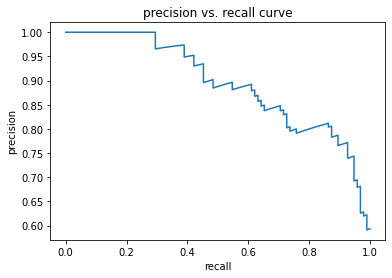

In [15]:
eval.plot_precisionrecall()

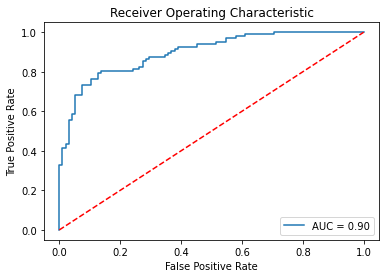

In [16]:
eval.plot_roc()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


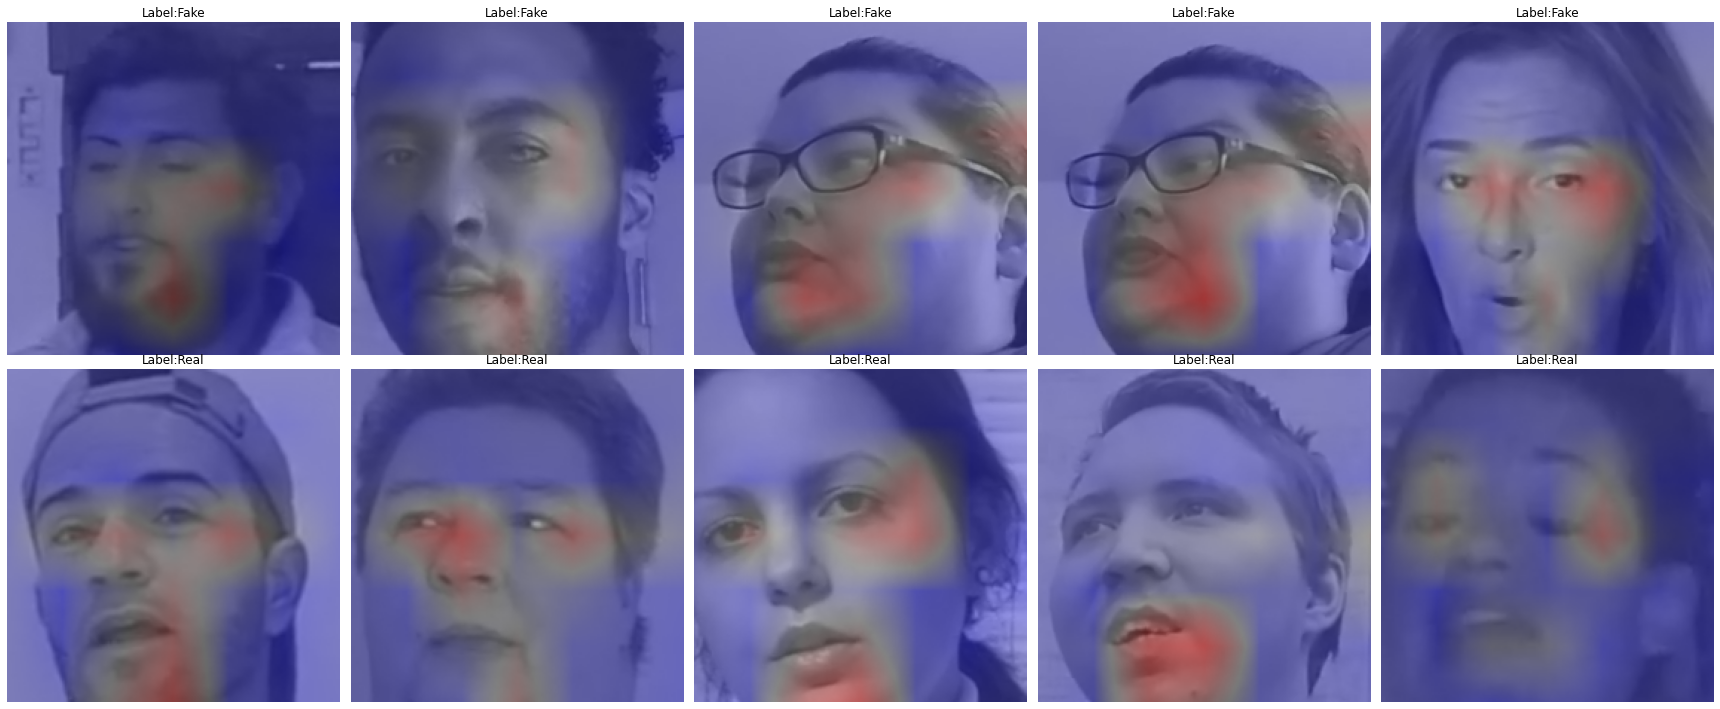

In [17]:
utils.visualize_attention(model,test_image_datasets,device,visualize_save_path)